<a href="https://colab.research.google.com/github/iserh/generative-models/blob/main/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluating Generative Adversarial Networks on the MNIST dataset
### Observations
- very unstable training
- convergence not guaranteed

In [1]:
%pylab inline
# pytorch (lightning)
import torch
import torch.nn as nn
# torchvision
import torchvision.utils as vutils
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
# other stuff
from tqdm.notebook import tqdm

# setting the device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Using device {device}')

Populating the interactive namespace from numpy and matplotlib
Using device cuda:0


### The MNIST Dataset

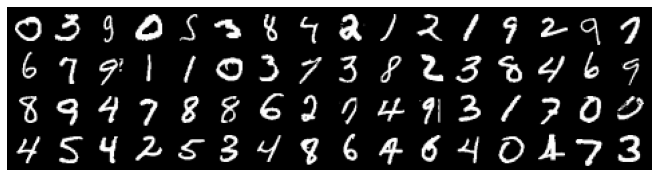

In [2]:
# load datasets
train_dataset = MNIST(root='~/torch_datasets', transform=ToTensor(), train=True, download=True)
test_dataset = MNIST(root='~/torch_datasets', transform=ToTensor(), train=False, download=True)
# create dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=2)
# visualize the dataset
figure(figsize=(12, 3))
imshow(np.transpose(vutils.make_grid(next(iter(train_loader))[0][:64], nrow=16), (1, 2, 0)))
axis('off')
show()

### The GAN Model

In [3]:
# weight initialization by normal distribution
def init_weights(m: nn.Module):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Sequential):
    def __init__(self, z_dim: int, image_channels: int, feature_maps: int):
        super(Generator, self).__init__(
            # input is (z_dim), going into a convolution
            nn.ConvTranspose2d(z_dim, feature_maps * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.ReLU(True),
            # state size: (feature_maps*4) x 4 x 4
            nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.ReLU(True),
            # state size: (feature_maps*2) x 7 x 7
            nn.ConvTranspose2d(feature_maps * 2, feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),
            # state size: (feature_maps) x 14 x 14
            nn.ConvTranspose2d(feature_maps, image_channels, 4, 2, 1, bias=False),
            nn.Sigmoid()
            # state size: (image_channels) x 28 x 28
        )
        # initialize weights
        self.apply(init_weights)
    def forward(self, z: torch.Tensor) -> torch.Tensor:
        # reshape z for convolutions and forward
        return super(Generator, self).forward(z.view(*z.shape, 1, 1))

class Discriminator(nn.Sequential):
    def __init__(self, image_channels: int, feature_maps: int):
        super(Discriminator, self).__init__(
            # state size: (image_channels) x 28 x 28
            nn.Conv2d(image_channels, feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (feature_maps) x 14 x 14
            nn.Conv2d(feature_maps, feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (feature_maps*2) x 7 x 7
            nn.Conv2d(feature_maps * 2, feature_maps * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (feature_maps*4) x 4 x 4
            nn.Conv2d(feature_maps * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        # initialize weights
        self.apply(init_weights)

class GAN(nn.Module):
    def __init__(self, image_channels: int, latent_dim: int, feature_maps_gen: int, feature_maps_disc: int):
        nn.Module.__init__(self)
        # generator and discriminator network
        self.generator = Generator(latent_dim, image_channels, feature_maps_gen)
        self.discriminator = Discriminator(image_channels, feature_maps_disc)
    def forward(self, noise: torch.Tensor) -> torch.Tensor:
        # generate from noise
        return self.generator(noise)

### Training the GAN

In [4]:
LATENT_DIM = 128

# create GAN model
gan = GAN(image_channels=1, latent_dim=LATENT_DIM, feature_maps_gen=8, feature_maps_disc=8)

# optimizer for generator network
optim_gen  = torch.optim.Adam(gan.generator.parameters(), betas=[0.5, 0.999], lr=2e-4)
# optimizer for discriminator network
optim_disc = torch.optim.Adam(gan.discriminator.parameters(), betas=[0.5, 0.999], lr=2e-4)

# loss criterion
criterion = nn.BCELoss()

# track some statistics and losses
losses_gen, losses_disc = [], []
predictions_d_x, predictions_d_g_z, predictions_d_g_z2 = [], [], []
step = 0

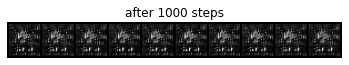

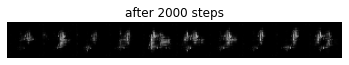

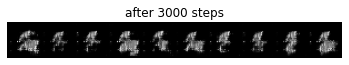

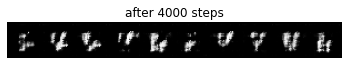

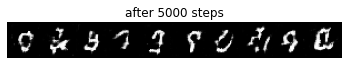

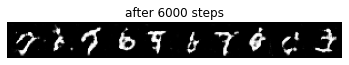

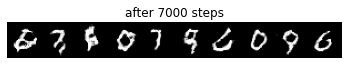

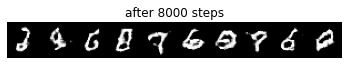

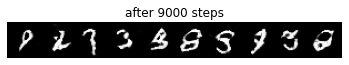

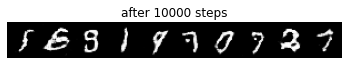

In [5]:
NUM_STEPS = 10_000
V_INTERVAL = 1_000

# move model to device and set to train mode
gan.to(device)
gan.train()

# Training Loop
with tqdm(total=NUM_STEPS, desc=f'Training', initial=step) as pbar:
    while step < NUM_STEPS:
        for x, _ in train_loader:
            step += 1
            # move real examples to device
            x = x.to(device)
            # sample noise from N(0, 1)
            z = torch.randn(x.size(0), LATENT_DIM, device=device)
            # generate example by generator network
            x_hat = gan(z)

            # *** Training the discriminator - maximize log(D(x)) + log(1 - D(G(z)))

            # compute discriminator output for real examples
            y_hat = gan.discriminator(x).view(-1)
            # append prediction mean to predictions list
            predictions_d_x.append(y_hat.mean().item())
            # create 'true' labels for discriminator
            y = torch.ones_like(y_hat)
            # compute loss for real examples on the discriminator output
            loss_disc = criterion(y_hat, y)

            # discriminator prediction
            y_hat = gan.discriminator(x_hat.detach()).view(-1)
            # append prediction mean to predictions list
            predictions_d_g_z.append(y_hat.mean().item())
            # create 'fake' labels for discriminator
            y = torch.zeros_like(y_hat)
            # compute loss for real examples on the discriminator output
            loss_disc += criterion(y_hat, y)

            # zero all gradients
            optim_disc.zero_grad()
            # backward loss
            loss_disc.backward()
            # perform optimizer step on the discriminator network
            optim_disc.step()
            # append discriminator loss to disc-losses
            losses_disc.append(loss_disc.item())

            # *** Training the generator - maximize log(D(G(z)))

            # discriminator prediction
            y_hat = gan.discriminator(x_hat).view(-1)
            # append prediction mean to predictions list
            predictions_d_g_z2.append(y_hat.mean().item())
            # create 'real' labels for discriminator
            y = torch.ones_like(y_hat)
            # compute loss for real examples on the discriminator output
            loss_g = criterion(y_hat, y)

            # zero all gradients
            optim_gen.zero_grad()
            # backward loss for real examples
            loss_g.backward()
            # perform optimizer step on the generator network
            optim_gen.step()
            # append generator loss to gen-losses
            losses_gen.append(loss_g.item())

            # progress bar
            pbar.set_postfix({
                'G-loss': losses_gen[-1],
                'D-loss': losses_disc[-1],
                'D(x)': predictions_d_x[-1],
                'D(G(z))': f'{predictions_d_g_z[-1]:.3f}/{predictions_d_g_z2[-1]:.3f}'
            })
            pbar.update()

            # visualize
            if step % V_INTERVAL == 0:
                # generate some images
                z = torch.randn(10, LATENT_DIM, device=device)
                gen_imgs = gan(z).cpu()

                # visualize the generated images
                figure()
                title(f'after {step} steps')
                imshow(np.transpose(vutils.make_grid(gen_imgs, nrow=10), (1, 2, 0)))
                axis('off')
                show()


            # stop training
            if step >= NUM_STEPS:
                break

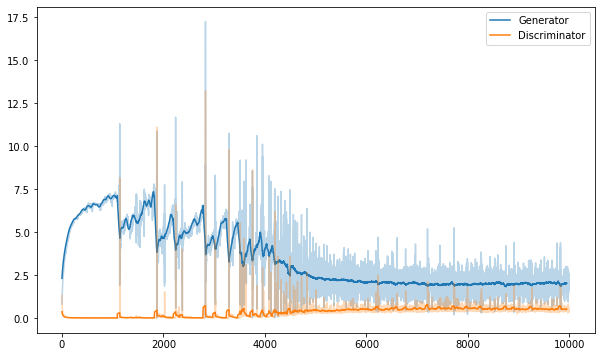

In [6]:
figure(figsize=(10, 6))
plot(np.arange(len(losses_gen)), losses_gen, alpha=.3, color='tab:blue')
plot(np.arange(len(losses_gen) - 49), np.convolve(losses_gen, np.ones(50)/50, mode='valid'), label="Generator", color='tab:blue')
plot(np.arange(len(losses_disc)), losses_disc, color='tab:orange', alpha=.3)
plot(np.arange(len(losses_disc) - 49), np.convolve(losses_disc, np.ones(50)/50, mode='valid'), label='Discriminator', color='tab:orange')
legend()
show()

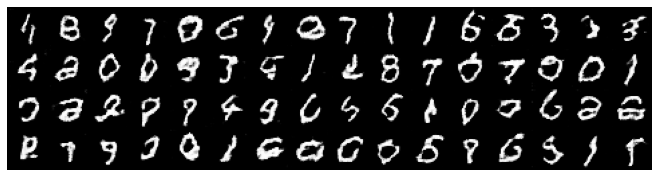

In [7]:
# generate some images
z = torch.randn(64, LATENT_DIM, device=device)
gen_imgs = gan(z).cpu()

# visualize the generated images
figure(figsize=(12, 3))
imshow(np.transpose(vutils.make_grid(gen_imgs, nrow=16), (1, 2, 0)))
axis('off')
show()